Google Colab is cool

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# Check current versions
!python -c "import numpy; print('Current numpy version:', numpy.__version__)"
!python -c "import torch; print('Current torch version:', torch.__version__)"

# Install desired versions with CUDA 12.4
!pip install numpy==1.26.4
!pip install torch==2.3.0+cu124 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.3.0+cu124.html
!pip install torcheeg
!pip install pytorch-lightning

# This will show the versions in new Python processes
!python -c "import numpy; print('Installed numpy version:', numpy.__version__)"
!python -c "import torch; print('Installed torch version:', torch.__version__)"

print("\n*** IMPORTANT: Please restart the runtime now for changes to take effect in this notebook  (search for 'restart session' in top left 'commands' ***")

Current numpy version: 2.0.2
Current torch version: 2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 74.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==2.3.0+cu124 (from versions: 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2

In [34]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

if torch.cuda.is_available():
    accelerator = "gpu"
    pin_memory = True
    print("GPU is available. Training will use GPU acceleration.")
else:
    accelerator = "cpu"
    pin_memory = False
    print("WARNING: GPU not available, using CPU instead")

PyTorch version: 2.6.0+cu124
CUDA version: 12.4


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
experiment_name = input("name your experiment (or use old one) > ")  # like sst_01

name your experiment (or use old one) > sst_04


In [30]:
import os

IO_PATH = f'/content/drive/MyDrive/datasets/STEW/io/{experiment_name}/' # not-existant or populated - ! NOT EMPTY !
MODEL_SAVE_PATH = f'/content/drive/MyDrive/datasets/STEW/model/{experiment_name}/' # is going to be created if it doesn't exist yet
DATA_FOLDER_PATH = '/content/drive/MyDrive/datasets/STEW/dataset' # has to exist

if not os.path.exists(MODEL_SAVE_PATH):
    print(f"model folder not existing, creating at {MODEL_SAVE_PATH}")
    os.mkdir(MODEL_SAVE_PATH)
else:
    print(f"ATTENTION: model folder already exists, only proceed if you are ready to overwrite")

if not os.path.exists(DATA_FOLDER_PATH):
    raise Exception("make sure dataset exists")


SEED:int = 42
BATCH_SIZE:int = 64
N_WORKERS:int = 2

model folder not existing, creating at /content/drive/MyDrive/datasets/STEW/model/sst_04/


# loading data

In [22]:
import os
import numpy as np
import mne
from typing import List, Dict
from tqdm import tqdm


def load_stew_dataset(stew_path: str, subjects: List[int] = None) -> tuple:
    """
    Load the STEW (Sustained-Task EEG Workload) dataset from TXT files.

    Parameters:
        stew_path (str): Path to the STEW dataset directory
        subjects (List[int], optional): List of subject IDs to load. If None, loads all available subjects.

    Returns:
        tuple: (raw_list, info_list) for use with MNERawDataset
    """
    # EEG channel names in the correct order
    channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

    # If no subjects specified, find all available subjects
    if subjects is None:
        subjects = set()
        for filename in os.listdir(stew_path):
            if filename.startswith('sub') and filename.endswith('.txt'):
                try:
                    subject_id = int(filename[3:5])
                    subjects.add(subject_id)
                except ValueError:
                    continue
        subjects = sorted(list(subjects))

    raw_list = []
    info_list = []

    # Task mapping
    task_mapping = {
        'lo': 'low',
        'hi': 'high'
    }

    for subject in tqdm(subjects):
        # Format subject ID with leading zero if needed
        subject_str = f"{subject:02d}"

        # Check for both task conditions
        for task_code in ['lo', 'hi']:
            filename = f"sub{subject_str}_{task_code}.txt"
            file_path = os.path.join(stew_path, filename)

            if os.path.exists(file_path):
                try:
                    # Load EEG data from txt file
                    eeg_data = np.loadtxt(file_path)

                    # Assume sampling rate of 128 Hz (adjust if different)
                    sfreq = 128

                    # Create MNE info structure
                    info = mne.create_info(
                        ch_names=channel_names,
                        sfreq=sfreq,
                        ch_types=['eeg'] * len(channel_names)
                    )

                    # Create Raw object
                    raw = mne.io.RawArray(eeg_data.T, info)

                    # Create metadata dictionary
                    metadata = {
                        'subject_id': subject,
                        'task': task_mapping[task_code],
                        'trial_id': task_code,
                        'workload_level': 0 if task_code == 'lo' else 1
                    }

                    raw_list.append(raw)
                    info_list.append(metadata)

                    # print(f"Loaded {filename}: {eeg_data.shape} samples")

                except Exception as e:
                    print(f"Error loading {file_path}: {e}")

    return raw_list, info_list


raw_list, info_list = load_stew_dataset(DATA_FOLDER_PATH)
print(f"\n\nLoaded {len(raw_list)} recordings from {len(set([info['subject_id'] for info in info_list]))} subjects")

100%|██████████| 48/48 [00:08<00:00,  5.46it/s]



Loaded 96 recordings from 48 subjects


In [23]:
for raw in raw_list:
    raw.filter(1, 45)

<RawArray | 14 x 19200 (150.0 s), ~2.1 MiB, data loaded>
['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'] None


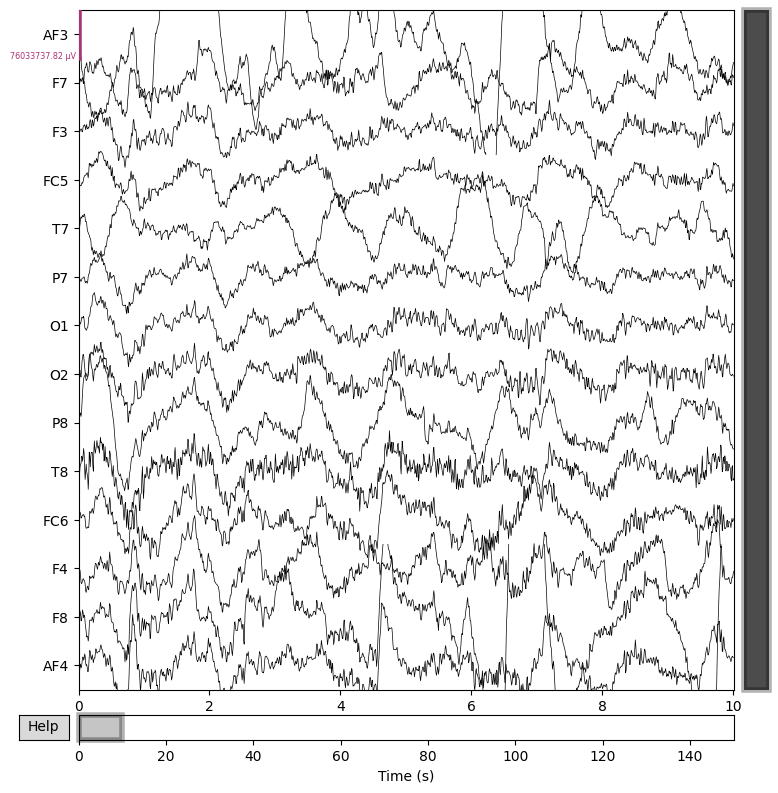

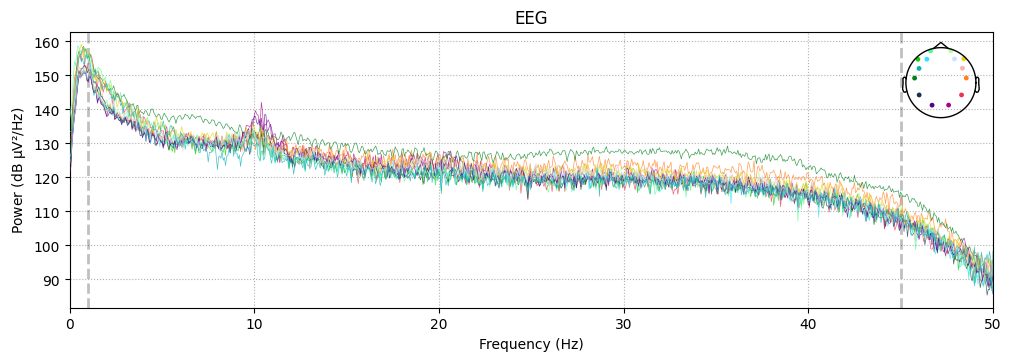

In [26]:
import random
import matplotlib.pyplot as plt

raw = random.choice(raw_list)

print(raw)
print(raw.info["ch_names"], raw.get_montage())

montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)

# raw.filter(1, 40)  # Bandpass filter from 1-40 Hz

# plot raw graph
fig = raw.plot(duration=10, n_channels=20, scalings='auto', title='Raw Data')

# Plot power spectral density
fig_psd = raw.plot_psd(fmax=50)

# plot the Power-Spectral-Density for each frequency - has a safety mechanism to not display frequencies you couldn't have captured (Nyquist-Shannon sampling theory)
# fig_psd_bands = raw.plot_psd_topo(fmax=60)

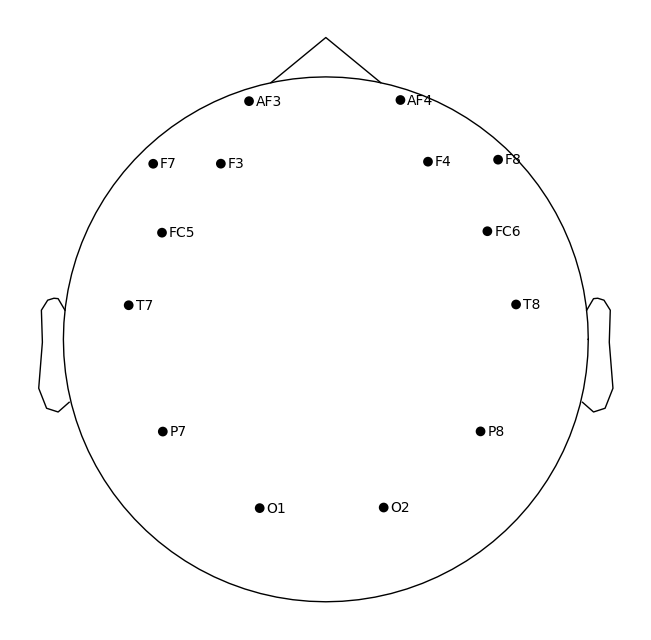

{'AF3': (-0.035186007467538326, 0.10912956509481905), 'F7': (-0.07187662505917264, 0.07310352742670875), 'F3': (-0.05180903841183724, 0.08668789888287941), 'FC5': (-0.07890597635539306, 0.05136738419239063), 'T7': (-0.08598207795805729, 0.014871638175652204), 'P7': (-0.07445796452347851, -0.042123164958505765), 'O1': (-0.03157355787465608, -0.08056835212663661), 'O2': (0.027683100559624117, -0.08048883980936473), 'P8': (0.07103247088902218, -0.04225997601209522), 'T8': (0.08326136985759491, 0.015258189278681372), 'FC6': (0.0778466192866476, 0.052098811200362666), 'F4': (0.050274277731628736, 0.08743838910239796), 'F8': (0.07143526925150917, 0.07450512647808137), 'AF4': (0.0342298581732583, 0.10981127208682755)}


In [27]:
# Plot topographic map of channel positions
fig_topo = raw.plot_sensors(show_names=True)

def get_channel_locations_from_mne(raw):
    """Extract channel locations from MNE object for TorchEEG."""
    # First ensure a montage is set
    if raw.get_montage() is None:
        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage)

    # Get positions (returns 3D coordinates)
    pos_3d = raw.get_montage().get_positions()['ch_pos']

    # Extract only the channels present in the raw object
    ch_names = raw.ch_names

    # Convert to 2D coordinates for TorchEEG (x,y)
    # We'll use the top-down view (x,y coordinates)
    location_dict = {}
    for ch in ch_names:
        if ch in pos_3d:
            # Get x,y coordinates (ignore z)
            x, y, _ = pos_3d[ch]
            location_dict[ch] = (x, y)

    return location_dict


# --- !! has to match the channel names in the info of the MNE raw objects
# STEW_CHANNEL_LOCATION_DICT = {
#     'AF3': (-0.3, 0.8),
#     'F7': (-0.8, 0.4),
#     'F3': (-0.4, 0.7),
#     'FC5': (-0.8, 0.0),
#     'T7': (-1.0, -0.2),
#     'P7': (-0.8, -0.6),
#     'O1': (-0.4, -1.0),
#     'O2': (0.4, -1.0),
#     'P8': (0.8, -0.6),
#     'T8': (1.0, -0.2),
#     'FC6': (0.8, 0.0),
#     'F4': (0.4, 0.7),
#     'F8': (0.8, 0.4),
#     'AF4': (0.3, 0.8)
# }

STEW_CHANNEL_LOCATION_DICT = get_channel_locations_from_mne(raw)

print(STEW_CHANNEL_LOCATION_DICT)

In [38]:
# import shutil
# shutil.rmtree(IO_PATH)

In [39]:
from torcheeg.datasets import MNERawDataset
from torcheeg import transforms
from torcheeg.datasets.constants import DREAMER_CHANNEL_LOCATION_DICT
from typing import Tuple

# https://ieee-dataport.org/open-access/stew-simultaneous-task-eeg-workload-dataset
# Wei Lun Lim, Olga Sourina, Lipo Wang, July 10, 2018, "STEW: Simultaneous Task EEG Workload Dataset", IEEE Dataport, doi: https://dx.doi.org/10.21227/44r8-ya50.
# we predict the cognitive load based on EEG data (by mapping hard tasks to "high" label and easy ones to "low" label)

# if this is throwing an error about corrupted, make sure the folder is
# populated by the right stuff (from running this thing the last time)
# or does NOT exist - will only run once and populate io path

# ---
# offline_transform = transforms.Compose([
#     transforms.Concatenate([

#         transforms.Compose([
#             transforms.BandDifferentialEntropy(
#                 band_dict={
#                     'theta': [4, 8],
#                     'alpha': [8, 13],
#                     'beta': [13, 30],
#                     'gamma': [30, 45]
#                 },
#                 sampling_rate=128
#             ),
#             transforms.MeanStdNormalize()
#         ]),

#         transforms.Compose([
#             transforms.Downsample(num_points=32),
#             transforms.MinMaxNormalize()
#         ])

#     ]),

#     transforms.ToInterpolatedGrid(STEW_CHANNEL_LOCATION_DICT)
# ])

offline_transform = transforms.Compose([
    transforms.BaselineRemoval(),
    transforms.Concatenate([
        transforms.Compose([
            transforms.BandDifferentialEntropy(sampling_rate=128),
            transforms.MeanStdNormalize()
        ]),
        transforms.Compose([
            transforms.Downsample(num_points=32),
            transforms.MinMaxNormalize()
        ])
    ]),
    transforms.ToInterpolatedGrid(STEW_CHANNEL_LOCATION_DICT)
])


online_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((16, 16))
])

label_transform = transforms.Compose([
    transforms.Select('workload_level')
])


# --- A. keep class and don't multiprocessing to avoid serialization problem
dataset = MNERawDataset(
    io_path=IO_PATH,

    raw_list=raw_list,
    info_list=info_list,
    chunk_size=640,  # 5 seconds at 128 Hz (better for cognitive load)
    overlap=320,     # 50% overlap

    offline_transform=offline_transform,
    online_transform=online_transform,
    label_transform=label_transform,

    num_worker=0,
    verbose=False
)

# ---

print(f"Dataset size: {len(dataset)}")
sample = dataset[0]
eeg_data, label = sample

print(f"EEG data shape: {eeg_data.shape}")
print(f"Label: {label}")

[2025-04-21 18:12:32] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to /content/drive/MyDrive/datasets/STEW/io/sst_04/.
INFO:torcheeg:🔍 | Processing EEG data. Processed EEG data has been cached to /content/drive/MyDrive/datasets/STEW/io/sst_04/.
[2025-04-21 18:12:32] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
INFO:torcheeg:⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
[2025-04-21 18:20:15] INFO (torcheeg/MainThread) ✅ | All processed EEG data has been cached to /content/drive/MyDrive/datasets/STEW/io/sst_04/.
INFO:torcheeg:✅ | All processed EEG data has been cached to /content/drive/MyDrive/datasets/STEW/io/sst_04/.
[2025-04-21 18:20:15] INFO (torcheeg/MainThread) 😊 | Please set io_path to /content/drive/MyD

Dataset size: 5664
EEG data shape: torch.Size([36, 16, 16])
Label: 0


In [40]:
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader


# validation is used during training for evaluating each batch
# test is saved to after (even if we don't train on val anyway, mechanisms like picking the best may still have 'val bias')
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"Dataset split: {train_size} training, {val_size} validation, {test_size} test samples")



# when training a GPU, we put the memory on a special 'pinned' region for faster transfer between CPU and GPU
# we shuffle the data in training to avoid it learning some patterns there (across batches) - no need on eval, since metrics will be the same
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_WORKERS,
    pin_memory=pin_memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=N_WORKERS,
    pin_memory=pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=N_WORKERS,
    pin_memory=pin_memory
)

# the grid:
# - channels mapped to a grid (not every one has an electrode)
# - each frequency band has its own grid, similar to how we have multiple values for RGB
# - determined by the DICT we enter into transform (though we might resize it)

for batch in train_loader:
    print(f"Input shape: {batch[0].shape}")
    break

# SST:([64, 36, 16, 16]) - ([batch_size, n_bands, grid_dim, grid_dim])

Dataset split: 3964 training, 849 validation, 851 test samples
Input shape: torch.Size([64, 36, 16, 16])


# initializing model

In [41]:
# depends on your dataset, duh?
N_CLASSES:int = 2

In [42]:
# --- SST (47min, stopped on epoch 35)
from torcheeg.models import SSTEmotionNet
model = SSTEmotionNet(
    temporal_in_channels=32, # 32 "frames" stacked
    spectral_in_channels=4, # 4 bands
    grid_size=(16, 16), # min size for some reason
    num_classes=N_CLASSES
)

#actual training (don't run for inference only)

In [43]:
from torcheeg.trainers import ClassifierTrainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

trainer = ClassifierTrainer(
    model=model,
    num_classes=N_CLASSES,
    lr=5e-5,
    weight_decay=1e-4,
    accelerator=accelerator,
    metrics=["accuracy", "precision", "recall", "f1score"]
)

callbacks = [
    # saves the best model (for recalling after plateu)
    ModelCheckpoint(
        dirpath=MODEL_SAVE_PATH,
        filename='best-model-{epoch:02d}-{val_accuracy:.4f}',
        monitor='val_accuracy',
        mode='max',
        save_top_k=1
    ),

    ModelCheckpoint(
        dirpath=MODEL_SAVE_PATH,
        filename='last-model',
        save_last=True
    ),

    # detect overfitting and end if val_accuracy stops improving for 10 epochs
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        mode='max',
        verbose=True
    )
]

In [44]:
print("\nStarting model training...")
trainer.fit(
    train_loader,
    val_loader,
    max_epochs=100,
    default_root_dir=MODEL_SAVE_PATH,
    callbacks=callbacks,
    enable_progress_bar=True,
    enable_model_summary=True
)

# ends once the trainer is done (so most likely through EarlyStop, otherwise max_epochs)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/datasets/STEW/model/sst_04 exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | SSTEmotionNet    | 525 K  | train
1 | ce_fn         | CrossEntropyLoss | 0      | train
2 | train_loss    | MeanMetric       | 0      | train
3 | val_loss      | MeanMetric       | 0      | train
4 | test_loss     | MeanMetric       | 0      | train
5 | train_metrics | MetricCollection | 0      | train
6 | val_metrics   | MetricCollection | 0      | train
7 | test_metrics  | MetricColle


Starting model training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:24:10] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.691 val_accuracy: 0.555 val_precision: 0.277 val_recall: 0.500 val_f1score: 0.357 
INFO:torcheeg:
[Val] val_loss: 0.691 val_accuracy: 0.555 val_precision: 0.277 val_recall: 0.500 val_f1score: 0.357 


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:26:23] INFO (torcheeg/MainThread) 
[Val] val_loss: 6418.185 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 6418.185 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:26:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_accuracy improved. New best score: 0.492


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:28:23] INFO (torcheeg/MainThread) 
[Val] val_loss: 58331392489238944546816.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 58331392489238944546816.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:28:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:30:21] INFO (torcheeg/MainThread) 
[Val] val_loss: 14862704503555096576.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 14862704503555096576.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:30:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:32:27] INFO (torcheeg/MainThread) 
[Val] val_loss: 1428728789860352.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 1428728789860352.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:32:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:34:26] INFO (torcheeg/MainThread) 
[Val] val_loss: 90630955008.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 90630955008.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:34:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:36:26] INFO (torcheeg/MainThread) 
[Val] val_loss: 925503.562 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 925503.562 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:36:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
print("\nEvaluating model on test set...")
test_results = trainer.test(test_loader)[0]
print(test_results)
print(f"Test accuracy: {test_results['test_accuracy']:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating model on test set...


Testing: |          | 0/? [00:00<?, ?it/s]

[2025-04-17 20:39:15] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.694 test_accuracy: 0.489 test_precision: 0.244 test_recall: 0.500 test_f1score: 0.328 
INFO:torcheeg:
[Test] test_loss: 0.694 test_accuracy: 0.489 test_precision: 0.244 test_recall: 0.500 test_f1score: 0.328 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.4888366758823395     │
│       test_f1score        │    0.32833465933799744    │
│         test_loss         │    0.6938510537147522     │
│      test_precision       │    0.24441833794116974    │
│        test_recall        │            0.5            │
└───────────────────────────┴───────────────────────────┘

{'test_loss': 0.6938510537147522, 'test_accuracy': 0.4888366758823395, 'test_precision': 0.24441833794116974, 'test_recall': 0.5, 'test_f1score': 0.32833465933799744}
Test accuracy: 0.4888


# loading model and doing inference

In [ ]:
!pip install onnx onnxruntime

In [ ]:
import os

for fname in os.listdir(MODEL_SAVE_PATH):
    if fname.startswith("best-model") and fname.endswith(".ckpt"):
        break


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


# continuing code will fail if for some reason there is no file called best-model-...ckpt
# (is automatically created due to our callbacks in training)
ckpt_path = MODEL_SAVE_PATH + fname

print(f"Loading {ckpt_path}")
checkpoint = torch.load(
    ckpt_path,
    map_location=device
)


if 'state_dict' in checkpoint:
    state_dict = {k.replace('model.', ''): v for k, v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
else:
    model.load_state_dict(checkpoint)

In [ ]:
for batch in train_loader:
    dummy_input = batch[0][0:2] # take small batch of two (so the dynamic batching will work)
    print(dummy_input.shape) # torch.Size([2, 36, 16, 16])
    break



onnx_path = MODEL_SAVE_PATH + "inference.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=13,
    do_constant_folding=True,
    input_names=["eeg_input"],
    output_names=["class_probabilities"],
    dynamic_axes={
        "eeg_input": {0: "batch_size"},
        "class_probabilities": {0: "batch_size"}
    }
)

In [ ]:
#
# loading model and doing inference to check if this works
#

import onnxruntime as ort
import numpy as np


session_options = ort.SessionOptions()
session_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] # fallbacks to CPU if CUDA isn't available


session = ort.InferenceSession(
    onnx_path,
    sess_options=session_options,
    providers=providers
)


input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name


# numpy is more efficient that tensors, and in inference we don't need AutoGrad features
test_batch = next(iter(test_loader))
test_data, test_labels = test_batch[0], test_batch[1]
test_data_np = test_data.numpy()


onnx_outputs = session.run([output_name], {input_name: test_data_np})
probabilities = onnx_outputs[0]
predicted_classes = np.argmax(probabilities, axis=1)
print(predicted_classes)